# Scaling from data manifold dimension: the case of CIFAR10

This notebook continues our question about explaining scaling laws from the data manifold dimension. The purpose of this notebook is to reproduce Figure 6 from the paper "Scaling laws from the data manifold dimension" (Sharma, Kaplan, 2022).

![](cifar_figure_6.png)"

In words, the figure is produced by training a standard CNN with 3 convolution layers and 2 fully connected layers on CIFAR-10. The CIFAR-10 dataset is a popular benchmark, consisting of 60,000 32x32 RGB images in 10 different classes, with 6,000 images per class. 

While the images live in a space of dimension $32^2 \times 3 = 3072$, (Sharma, Kaplan, 2022) reports that the CIFAR-10 images lies in a data manifold with dimension of only around 16--18.

In order to run a controlled experiment, the experiments were run by varying as few parameters as possible. The training is done with the following designs:
* The network architecture is fixed, and the network parameter count is changed by changing a single number: the number of channels in the convolutional layers.
* Each training run lasts 50 epochs, with batch size 128.
* Optimizer is `AdamW` with `lr=5e-4`.

The experiment is run with 20 different network sizes, from 5408 to 115114.

I generated all the data and logged them into tensorboard log files -- it took about 4 days of on-and-off computing (I don't have a powerful GPU). You can view them for yourself to get a feel for the shape of the dataset, by running `tensorboard --logdir=cifar10/logs`. Suffice to say that the dataset is not very clean, and accidents sometimes happen.

* A few training runs terminated early thanks to GPU running out of memory, or the computer going to sleep. A few training runs got mashed together into the same logging file due to my choosing to start multiple training runs in parallel, and since they were all started at the exact same second, they all logged into the exact same file with the exact same name.
* Some training runs only started decreasing in loss after a few epochs. A few training runs completely failed to train, with loss curves not decreasing. These delays and failures are not consistently reproducible. I have not managed to find out why, presumably due to some trivial accident.

Despite these accidents, it is clean enough for us to proceed, with a little caution.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from tbparse import SummaryReader
import numpy as np
plt.rcParams.update({'font.size': 16,
                     'figure.titlesize':"large",
                    'axes.titlesize':"large"})

In [2]:
dfs = []

for i in range(1, 21):
    reader = SummaryReader(f"./cifar10/logs/n_{i}")
    df_text = reader.text
    model_size = df_text.loc[df_text['tag'] == 'Model size', 'value'].iloc[0]
    
    df_scalars = reader.scalars
    
    # Add "channel" and "size" columns to the scalars DataFrame
    df_scalars['channel'] = i
    df_scalars['size'] = model_size
    
    dfs.append(df_scalars)

df = pd.concat(dfs, ignore_index=True)
print(df)

        step              tag     value  channel    size
0          0   Accuracy/Train  0.183840        1    5408
1          0   Accuracy/Train  0.145320        1    5408
2          0   Accuracy/Train  0.179360        1    5408
3          0   Accuracy/Train  0.196200        1    5408
4          0   Accuracy/Train  0.160180        1    5408
...      ...              ...       ...      ...     ...
164923    49  Loss/Validation  0.750074       20  115114
164924    49  Loss/Validation  0.728727       20  115114
164925    49  Loss/Validation  0.748184       20  115114
164926    49  Loss/Validation  0.755237       20  115114
164927    49  Loss/Validation  0.738370       20  115114

[164928 rows x 5 columns]


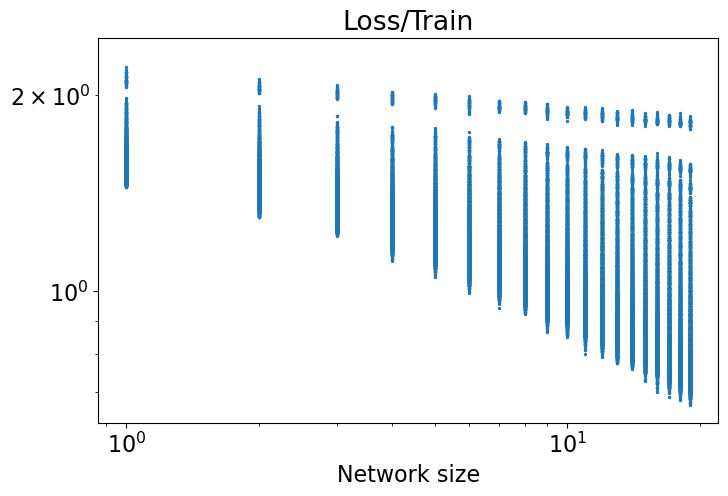

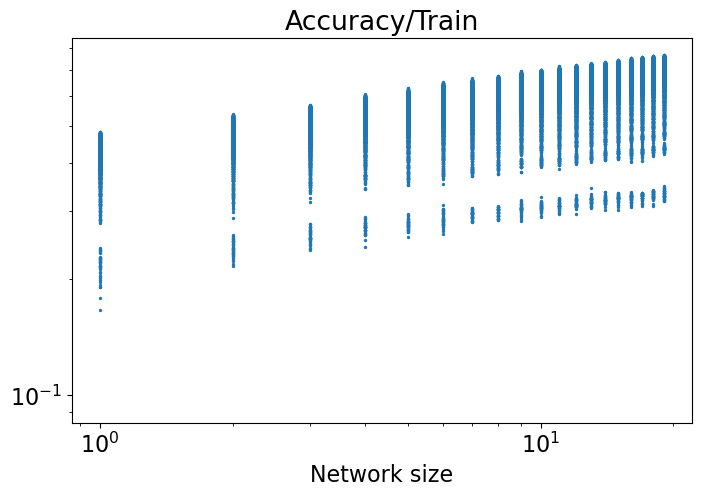

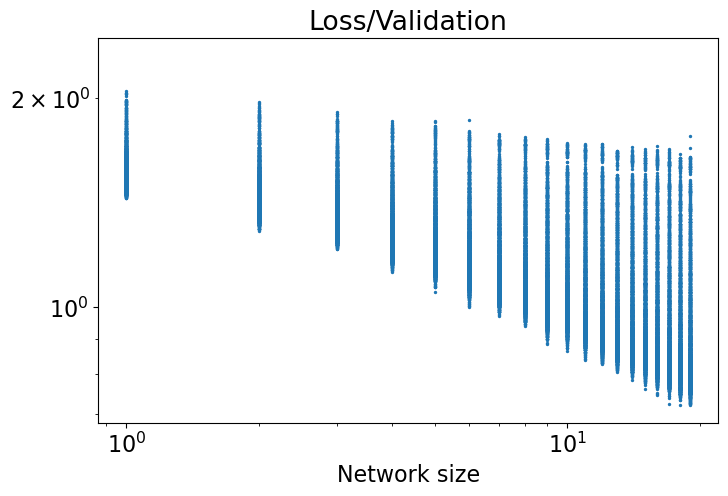

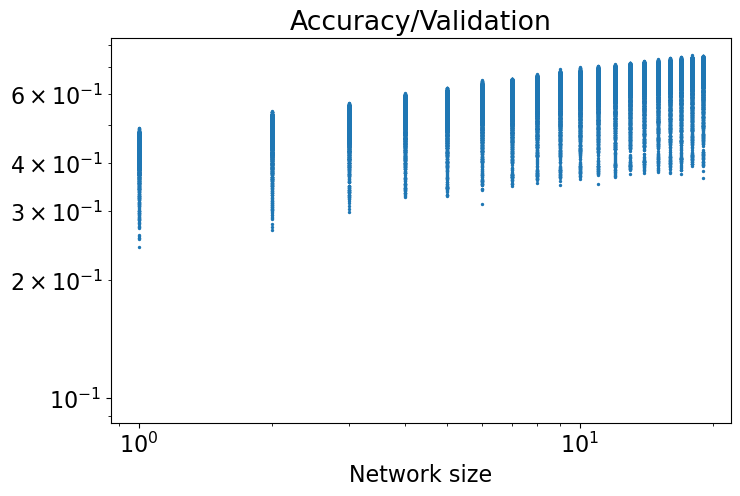

In [4]:
for tag in ["Loss/Train", "Accuracy/Train", "Loss/Validation", "Accuracy/Validation"]:
    filtered_df = df[df['tag'] == tag]
    
    plt.figure(figsize=(8, 5))
    plt.scatter(filtered_df['size'], filtered_df['value'], s=2)
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'{tag}')
    plt.xlabel('Network size')
    plt.ylabel('')
    plt.show()

The plots are not as clean as we like, because of some outliers due to failed or unlucky training runs. It is easier to see if we use the violin plot:

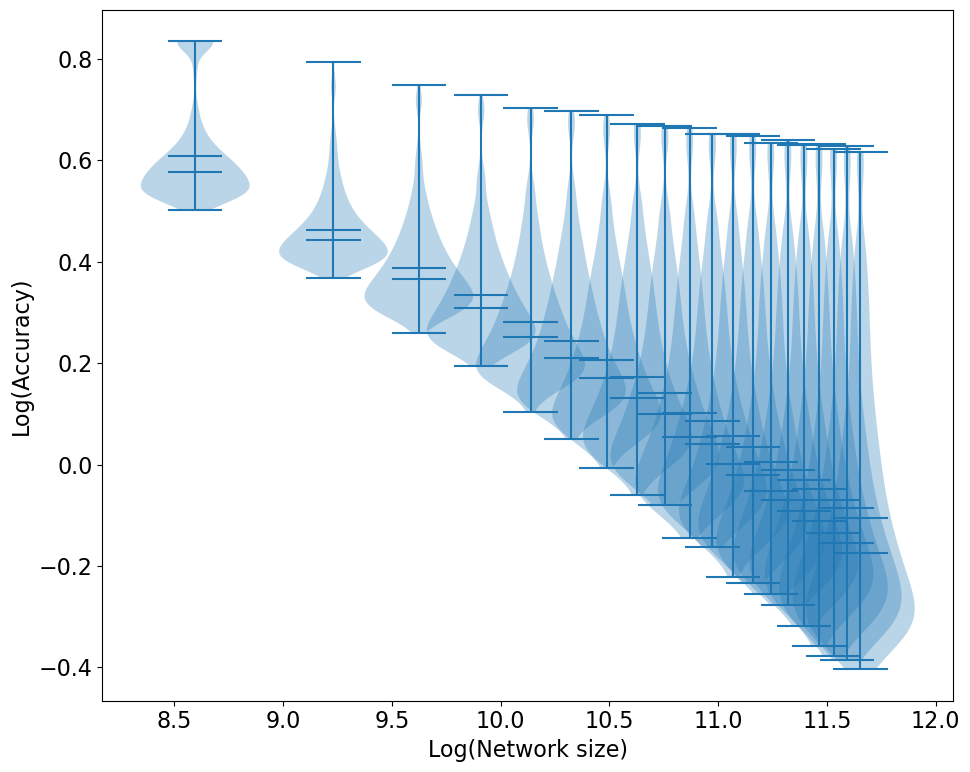

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
filtered_df = df[df['tag'] == "Loss/Train"]
network_sizes = filtered_df['size'].unique()

data = [np.log(filtered_df[filtered_df['size'] == size]['value']) for size in network_sizes]
ax.violinplot(data, np.log(network_sizes.astype('float')),
                             showmeans=True, showextrema=True, showmedians=True, 
                             bw_method='scott')
ax.set_xlabel('Log(Network size)')
ax.set_ylabel('Log(Accuracy)')

plt.tight_layout()
plt.show()

Now, create a plot that contains all 4 plots as subplots, for the training loss, validation loss, training accuracy, and validation accuracy.

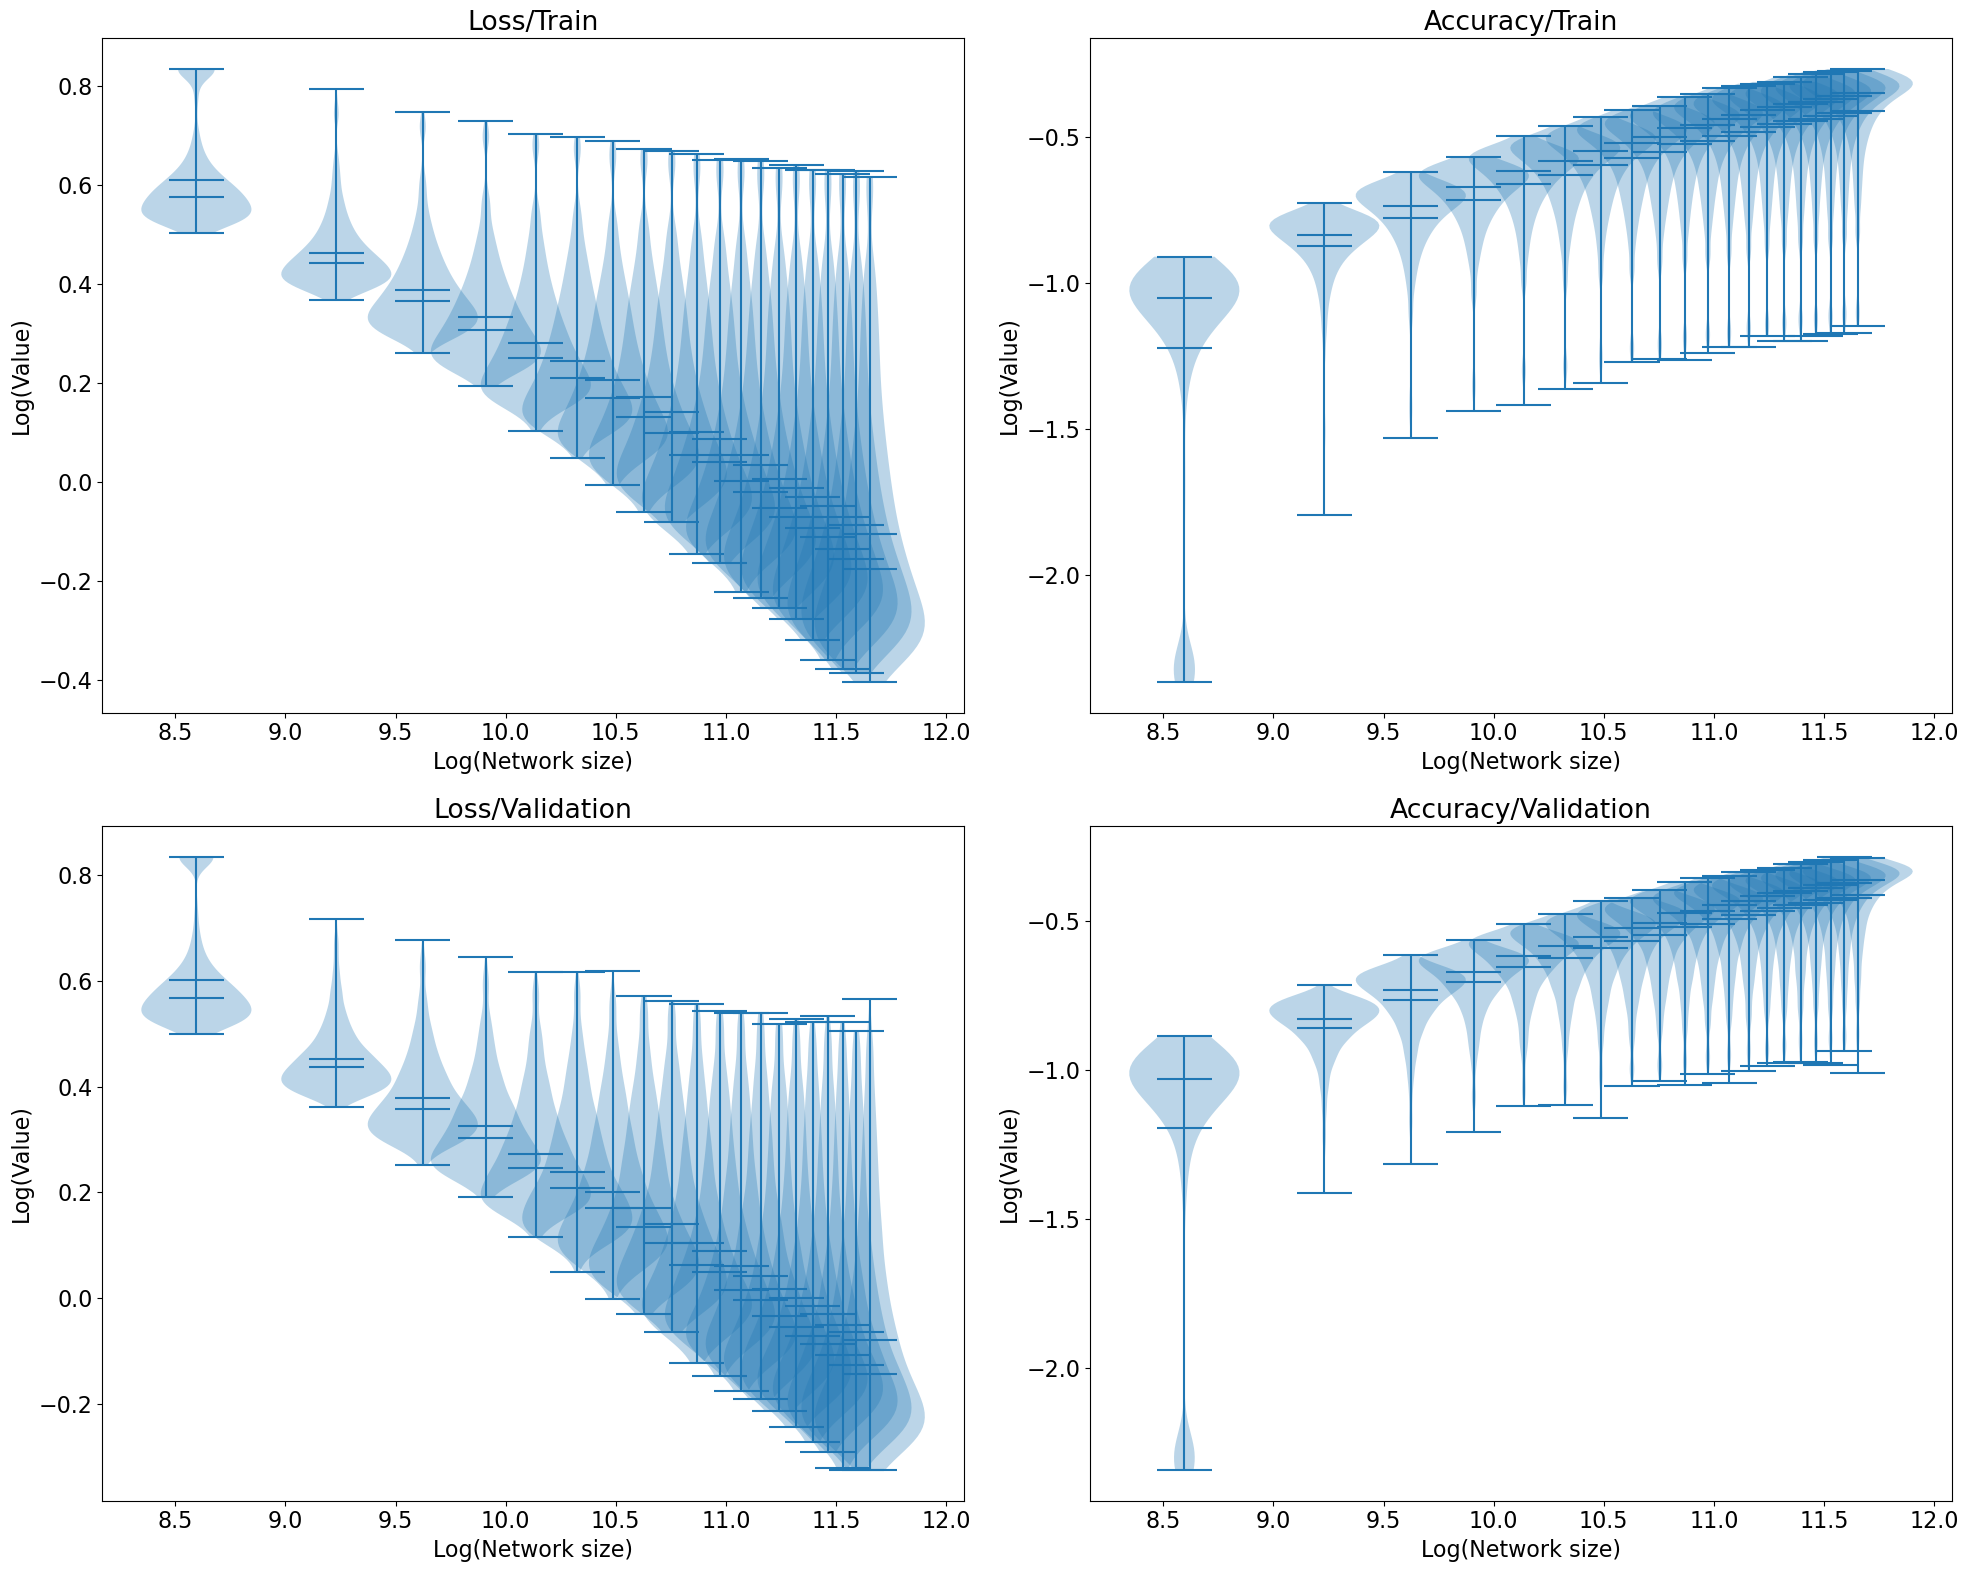

In [121]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 16))
############################################################################
# TODO: create the diagram
############################################################################
tags = ["Loss/Train", "Accuracy/Train", "Loss/Validation", "Accuracy/Validation"]

network_sizes = filtered_df['size'].unique()

for i, tag in enumerate(tags):
    filtered_df = df[df['tag'] == tag]
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    
    data = [np.log(filtered_df[filtered_df['size'] == size]['value']) for size in network_sizes]
    ax.violinplot(data, np.log(network_sizes.astype('float')),
                                 showmeans=True, showextrema=True, showmedians=True, 
                                 bw_method='scott')
    ax.set_title(f'{tag}')
    ax.set_xlabel('Log(Network size)')
    ax.set_ylabel('Log(Value)')
############################################################################
plt.tight_layout()
plt.show()

It looks pretty good. There are some small outliers, which are due to the unsuccessful training runs. We could have manually removed the unsuccessful training runs, but it's less effort to just run quantil regression, which can ignore the outliers quite well.

With this, we can find the scaling law slopes $\alpha$ by $0.5$-quantile regression (median regression) and compare $\frac 4\alpha$ with the theoretical expectation of around 16--18.

Read up on [quantile regression from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.QuantileRegressor.html), then implement the function below. For reference, here is one of the plots we expect you to create:

![](quantile_regression_plot.png)

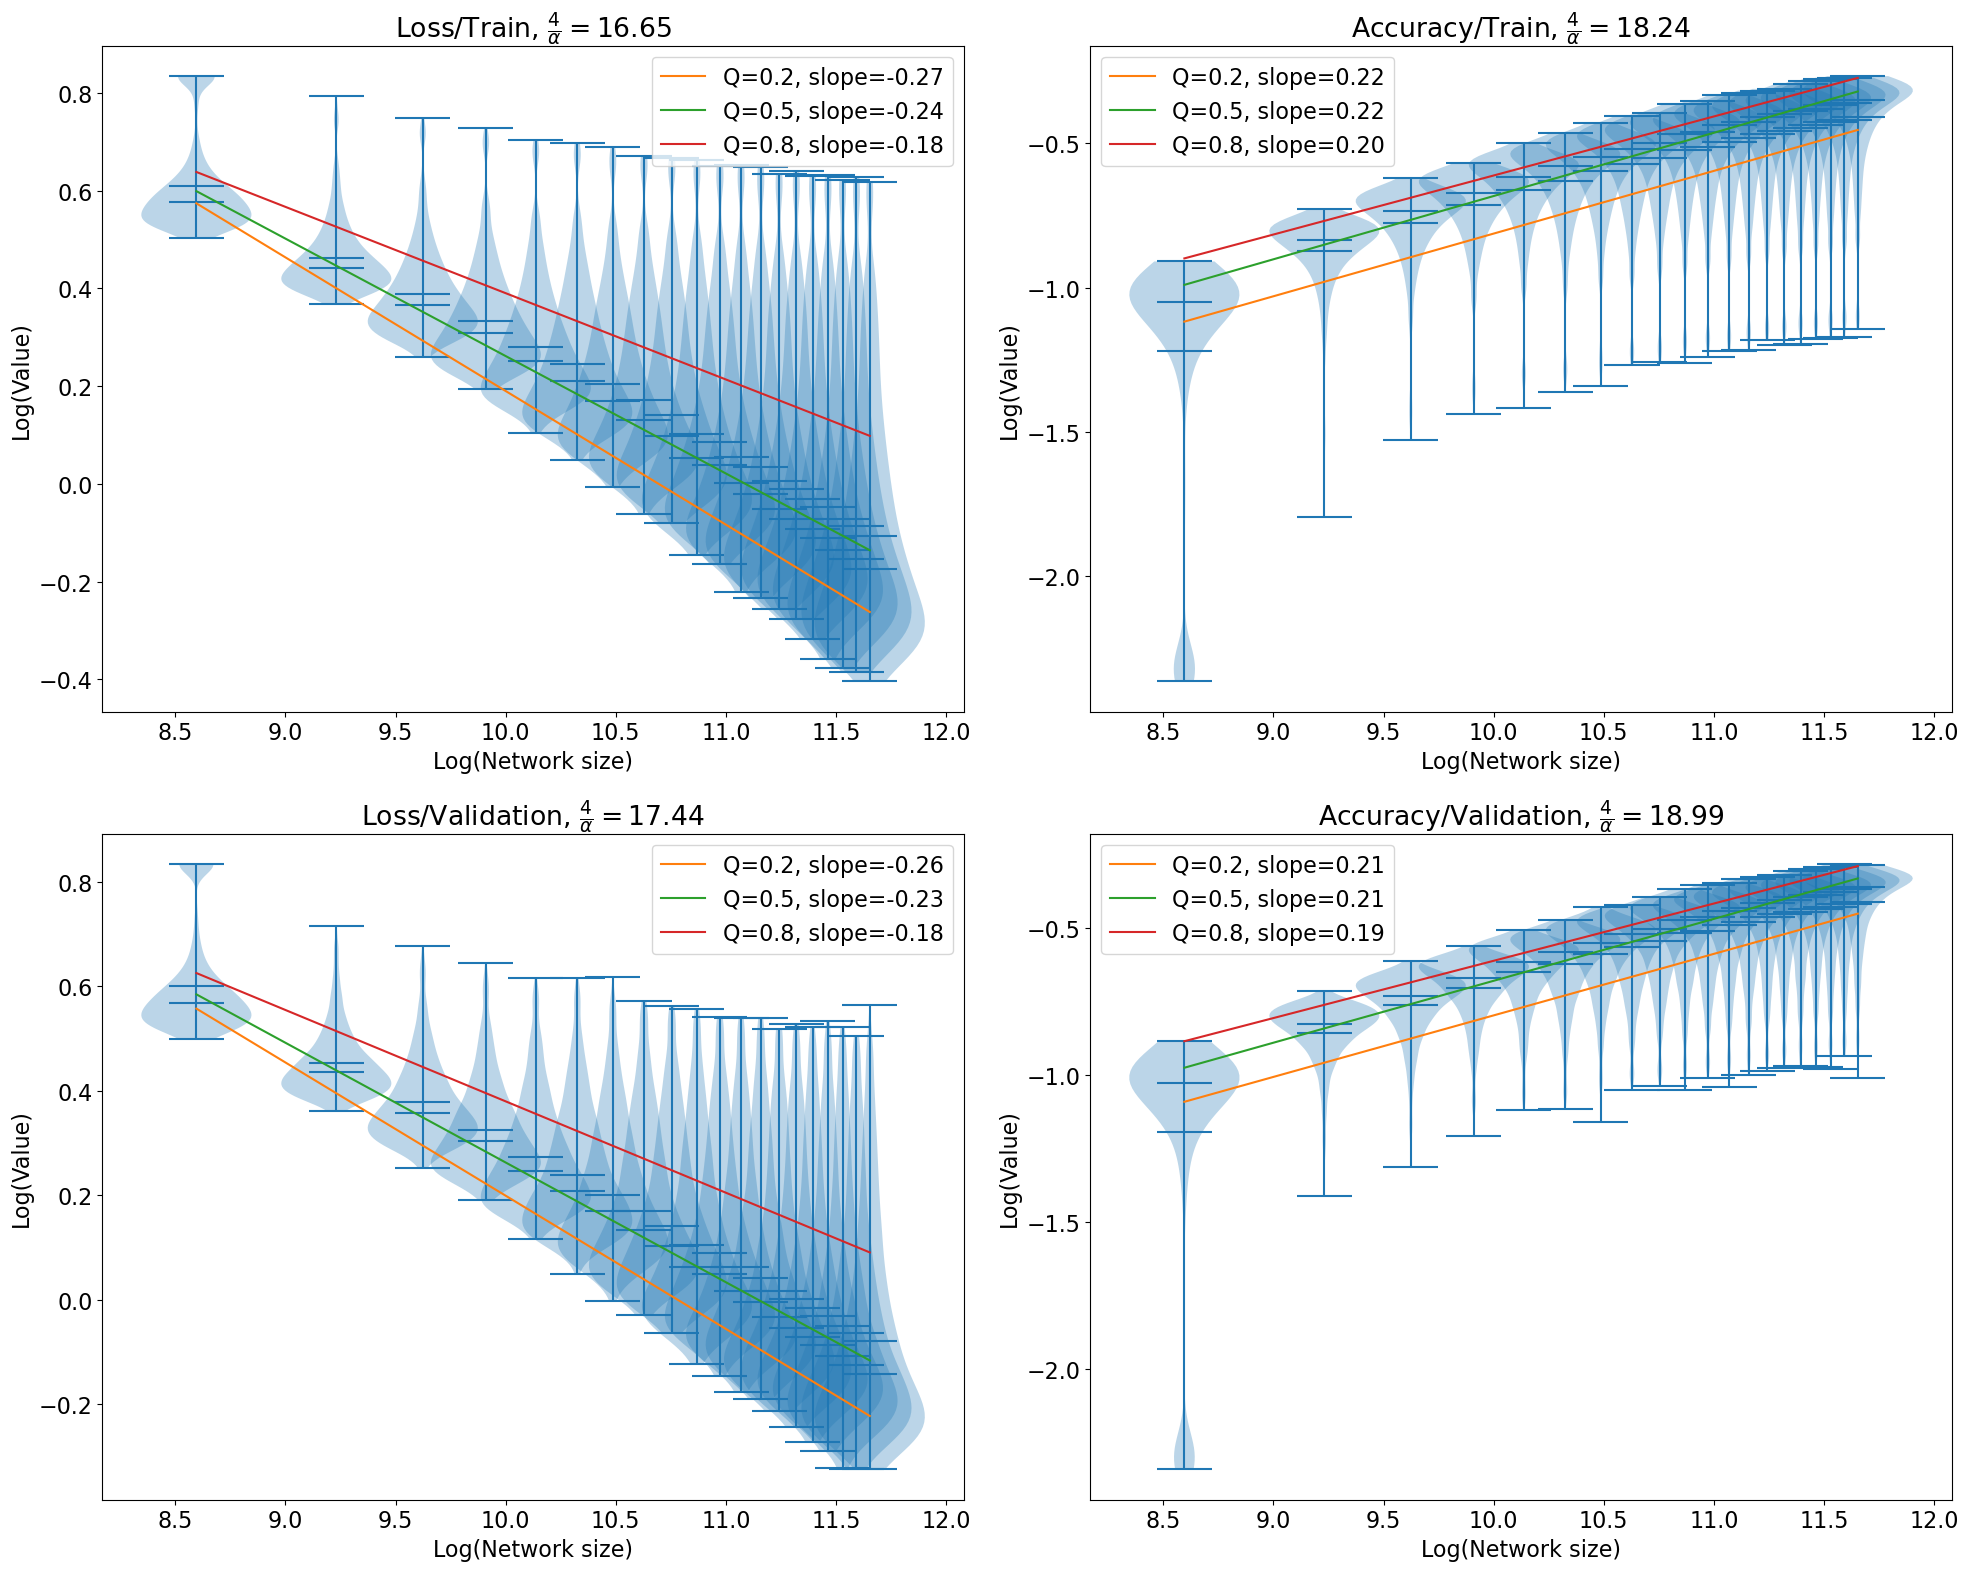

In [128]:
from sklearn.linear_model import QuantileRegressor
quantiles = [0.2, 0.5, 0.8]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 16))
############################################################################
# TODO: perform quantile regression, and plot it on the graph
############################################################################
tags = ["Loss/Train", "Accuracy/Train", "Loss/Validation", "Accuracy/Validation"]
network_sizes = filtered_df['size'].unique()

for i, tag in enumerate(tags):
    filtered_df = df[df['tag'] == tag]
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    
    data = [np.log(filtered_df[filtered_df['size'] == size]['value']) for size in network_sizes]
    ax.violinplot(data, np.log(network_sizes.astype('float')),
                                 showmeans=True, showextrema=True, showmedians=True, 
                                 bw_method='scott')

    X = np.log(filtered_df['size'].astype('float')).values.reshape(-1, 1)
    y = np.log(filtered_df['value'])
    
    predictions = {}
    
    for quantile in quantiles:
        qr = QuantileRegressor(quantile=quantile, alpha=0, solver="highs-ipm")
        y_pred = qr.fit(X, y).predict(X)
        predictions[quantile] = (y_pred, qr.coef_[0], qr.intercept_)
    alpha = predictions[0.5][1]
        
    for quantile in quantiles:
        ax.plot(np.log(filtered_df['size'].astype('int')), predictions[quantile][0], 
                label=f"Q={quantile}, slope={predictions[quantile][1]:.2f}")
    
    ax.set_title(fr'{tag}, $\frac{{4}}{{\alpha}} = {np.abs(4/alpha):.2f}$')
    ax.set_xlabel('Log(Network size)')
    ax.set_ylabel('Log(Value)')
    ax.legend()
############################################################################
plt.tight_layout()
plt.show()

Now that you have the figures, compare them with the published figures. Have we successfully reproduced the paper? According to our graphs, what appears to be the intrinsic dimension of the CIFAR10 data manifold?

############################################################################

TODO: answer the question

############################################################################

We have reproduced the paper indeed. I would say they look even better than the paper itself. 

According to our data, the data manifold appears to have intrinsic dimension in the range 17 -- 19.

############################################################################